<a href="https://colab.research.google.com/github/polesh21/iowa_liquor_sales/blob/stage/EDA_iowa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

# Connect to Google Bigquery public data "iows_luqior_sales"



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#ensure the file is accessible
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/temp

DPolieshko-0cf48e53ce74.json


In [0]:
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/gdrive/My Drive/Colab Notebooks/temp/DPolieshko-0cf48e53ce74.json"

In [5]:
#ensure the path is set correctly
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/gdrive/My Drive/Colab Notebooks/temp/DPolieshko-0cf48e53ce74.json


In [0]:
client = bigquery.Client()

In this analysis we are going to extract data for 2017-2019:


In [0]:
sql = '''
        SELECT *
        FROM `bigquery-public-data.iowa_liquor_sales.sales`
         where date >='2017-01-01' and date <='2019-12-31'
        '''

df = client.query(sql).to_dataframe()

# Data preparation

In [8]:
df[['store_name','county','category_name','vendor_name','item_description','category_name']].describe()
 #   'bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters']].describe()

,store_name,county,category_name,vendor_name,item_description,category_name
count,7027179,6977246,7019110,7027176,7027179,7019110
unique,2007,132,55,250,5303,55
top,Hy-Vee #3 / BDI / Des Moines,POLK,American Vodkas,DIAGEO AMERICAS,Black Velvet,American Vodkas
freq,63906,1160867,1063138,1193449,182819,1063138



Several text columns appear to have not equal number of values. That's why we need to drop na values and remove duplicates in our table

In [0]:
df = df.dropna()
df = df.drop_duplicates()


Now we can identify most frequent values in our columns

In [10]:
df[['store_name','county','category_name','vendor_name','item_description','category_name']].describe()
 #   'bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters']].describe()

,store_name,county,category_name,vendor_name,item_description,category_name
count,6315669,6315669,6315669,6315669,6315669,6315669
unique,1863,129,55,243,5090,55
top,Hy-Vee #3 / BDI / Des Moines,POLK,American Vodkas,DIAGEO AMERICAS,Black Velvet,American Vodkas
freq,63770,1032853,958487,1072822,166209,958487


Let's check data types in our table

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6315669 entries, 0 to 7027178
Data columns (total 24 columns):
invoice_and_item_number    object
date                       object
store_number               object
store_name                 object
address                    object
city                       object
zip_code                   object
store_location             object
county_number              object
county                     object
category                   object
category_name              object
vendor_number              object
vendor_name                object
item_number                object
item_description           object
pack                       int64
bottle_volume_ml           int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold               int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtypes: float64(5), int64(3), object(16)
memory usage: 1.2+ GB


We notice that column with dates isn't actually a date column. Let's fix it

In [11]:
#convert date column to date type
df['date']= pd.to_datetime(df['date'])

#make additional columns for further analysis
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week_num'] = df['date'].dt.dayofweek
df['day_of_week'] = df['date'].dt.weekday_name
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,month,year,day_of_week_num,day_of_week
0,INV-22062200070,2019-09-23,2552,Hy-Vee Food Store #3 / Cedar Rapids,20 Wilson Avenue West,Cedar Rapids,52404,POINT (-91.658577 41.955859),57,LINN,1081600,Whiskey Liqueur,121,COOPER SPIRITS INTERNATIONAL,74740,Slow and Low,6,750,12.17,18.26,6,118.56,4.50,1.18,9,2019,0,Monday
1,INV-19241400019,2019-05-08,4609,Kum & Go #579 / Ankeny,165 SW Magazine Rd,Ankeny,50023,POINT (-93.602007 41.717286),77,Polk,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64865,Fireball Cinnamon Whiskey PET,12,750,8.98,13.47,6,80.82,4.50,1.18,5,2019,2,Wednesday
2,INV-19084500011,2019-05-01,4767,Casey's General Store #3075 / Ankeny,6981 NE 14th St,Ankeny,50023,POINT (-93.600659 41.687793000000006),77,Polk,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,86884,Southern Comfort,24,375,4.78,7.17,12,86.04,4.50,1.18,5,2019,2,Wednesday
3,INV-22554900004,2019-10-15,4980,Pronto BP,7305 Laporte Rd,Washburn,50702,POINT (-92.264665 42.409095),7,Black Hawk,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64865,Fireball Cinnamon Whiskey PET,12,750,8.98,13.47,6,80.82,4.50,1.18,10,2019,1,Tuesday
4,INV-22243700017,2019-10-01,5519,Casey's General Store #3648 / Akron,80 South St,Akron,51001,POINT (-96.56323 42.823106),75,PLYMOUTH,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64865,Fireball Cinnamon Whiskey PET,12,750,8.98,13.47,6,80.82,4.50,1.18,10,2019,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027173,INV-10722800103,2018-03-05,2653,Hy-Vee Wine and Spirits / Washington,1004 W Madison St,Washington,52353,POINT (-91.704567 41.296576),92,WASHINGTON,1081600,Whiskey Liqueur,260,DIAGEO AMERICAS,66203,Piehole Apple Pie,12,750,7.49,11.24,2,22.48,1.50,0.40,3,2018,0,Monday
7027174,INV-20525300090,2019-07-10,2605,Hy-Vee Drugstore #5 / Cedar Rapids,2001 Blairs Ferry Road NE,Cedar Rapids,52402,POINT (-91.668909 42.034799),57,LINN,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,66203,Piehole Apple Pie,12,750,7.49,11.24,3,33.72,2.25,0.59,7,2019,2,Wednesday
7027175,INV-21878300041,2019-09-13,2612,Hy-Vee Store / Perry,1215 141 St,Perry,50220,POINT (-94.104501 41.830292),25,DALLAS,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,66203,Piehole Apple Pie,12,750,7.49,11.24,3,33.72,2.25,0.59,9,2019,4,Friday
7027176,INV-13091200020,2018-07-06,2602,Hy-Vee Food Store / Webster City,823 2nd St,Webster City,50595,POINT (-93.825486 42.469466),40,HAMILTON,1081600,Whiskey Liqueur,260,DIAGEO AMERICAS,66208,Piehole Cherry Pie,12,750,7.49,11.24,3,33.72,2.25,0.59,7,2018,4,Friday


# Data Analysis

Let's find annual sold liters amount

In [14]:
by_year = df.groupby(['year']).sum().reset_index()
liters_by_year = by_year[['year','volume_sold_liters']]

#remove scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

liters_by_year

,year,volume_sold_liters
0,2017,18784995.16
1,2018,19959044.48
2,2019,20395769.02


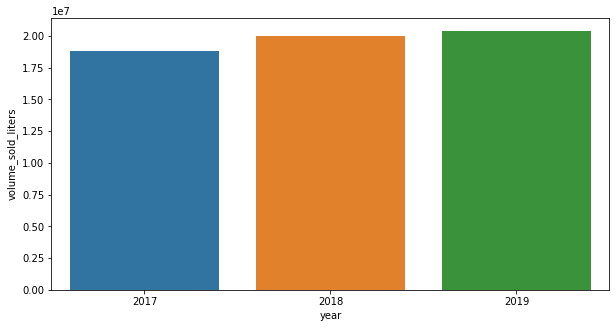

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,5)
sns.barplot(x='year',y='volume_sold_liters',data=liters_by_year)

Sold liters amound slightly tends to grow from year to year

Then we want to find monthly dynamics of volumes sold

In [16]:
by_month = df.groupby(['month']).sum().reset_index()
liters_by_month = by_month[['month','volume_sold_liters']]
liters_by_month

,month,volume_sold_liters
0,1,3992362.34
1,2,4374604.13
2,3,4443313.45
3,4,4718679.60
4,5,5600887.81
5,6,5199680.07
6,7,5025944.05
7,8,5204768.57
8,9,4523443.80
9,10,5612335.03


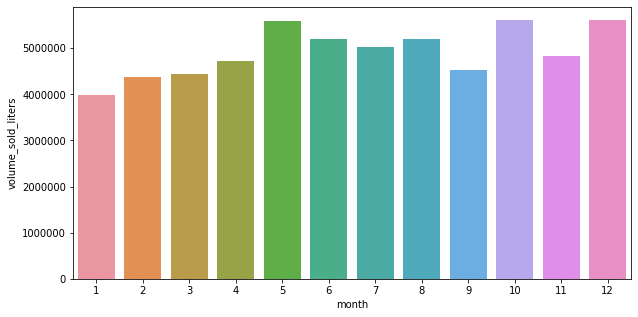

In [17]:
sns.barplot(x='month',y='volume_sold_liters',data=liters_by_month)

May, October and December appears to be the months with highest sold amounts;  January - with lowest

Daily dynamics

In [18]:
by_day = df.groupby(['day_of_week_num','day_of_week']).sum().reset_index()
liters_by_day = by_day[['day_of_week_num','day_of_week','volume_sold_liters']]
liters_by_day

,day_of_week_num,day_of_week,volume_sold_liters
0,0,Monday,12871843.84
1,1,Tuesday,12430716.43
2,2,Wednesday,12815284.63
3,3,Thursday,12667278.59
4,4,Friday,8028630.44
5,5,Saturday,318307.19
6,6,Sunday,7747.54


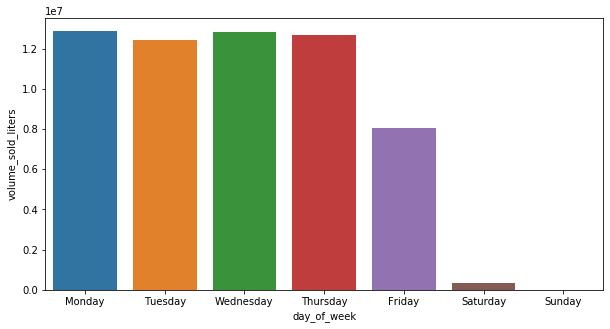

In [19]:
sns.barplot(x='day_of_week',y='volume_sold_liters',data=liters_by_day)

Liquor trade deals are closing mainly on working days. Although, total amounts sold on Friday are 1.5x lower than on any other working day

Let's find top-10 cities based on total_volume_sold_liters metric


In [22]:
сities_all = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['city'], 
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()

сities_all.columns = ['city', 'total_bottles_sold','total_sale_dollars', 'average_bottle_cost','average_state_bottle_retail','total_volume_sold_liters']

сities_all = сities_all.sort_values(by='total_volume_sold_liters', ascending = False)
сities_all['perc_volume_sold_liters'] = сities_all['total_volume_sold_liters']/сities_all['total_volume_sold_liters'].sum()
сities_all['cum_perc_volume_sold_liters'] = сities_all['perc_volume_sold_liters'].cumsum()

сities_all.head(10)

,city,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters,perc_volume_sold_liters,cum_perc_volume_sold_liters
103,Des Moines,9298489,120228325.14,10.62,15.93,6944199.47,0.12,0.12
58,Cedar Rapids,5081923,63669053.52,9.96,14.94,4140881.71,0.07,0.19
93,Davenport,3581472,40591145.58,9.54,14.31,2601383.49,0.04,0.23
410,West Des Moines,2196995,34661601.47,11.03,16.54,2134629.79,0.04,0.27
351,Sioux City,2556953,33318306.35,10.32,15.48,2103556.77,0.04,0.30
85,Council Bluffs,2533833,31864398.02,9.62,14.43,2017998.46,0.03,0.34
399,Waterloo,2870304,30859116.41,9.10,13.65,1883899.08,0.03,0.37
192,Iowa City,2180106,29804335.09,10.48,15.72,1866179.87,0.03,0.40
108,Dubuque,1667467,22370781.81,10.30,15.45,1464046.66,0.02,0.43
16,Ames,1471988,21400066.30,11.40,17.10,1445232.05,0.02,0.45


Des Moines has 12% of all volume sold in Iowa; 45% of all sales in Iowa have taken place in top-10 cities

For better understanding let's visualize all volumes by city using a treemap and label first top-20 cities

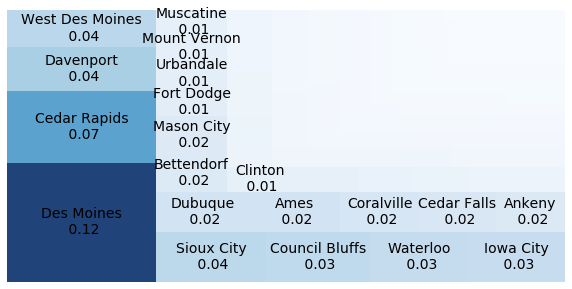

In [69]:
#disable chained_assignment warning
pd.options.mode.chained_assignment = None

top_cities_df = сities_all.head(20)
top_cities_df['label'] = top_cities_df['city'] + "\n " + top_cities_df['perc_volume_sold_liters'].round(2).astype(str)
top_cities = top_cities_df['label'].tolist()

#using squarify
!pip install -q squarify
import squarify    
import matplotlib as mpl

# create a color palette, mapped to these values
cmap = mpl.cm.Blues
mini=сities_all['perc_volume_sold_liters'].min()
maxi=сities_all['perc_volume_sold_liters'].max()
norm = mpl.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in сities_all['perc_volume_sold_liters']]

squarify.plot(sizes=сities_all['perc_volume_sold_liters'], label=top_cities, alpha=.9, color=colors)
plt.rc('font', size=14)
plt.axis('off')
plt.show()